# Class Activation Map & Gradient  Class Activation Map
  
Goal of this project:  
- Summarize CAM and GCAM Papers  
- Visualize CAM & GCAM at each epoch to find the optimal points in model
- Create Image Detection Boxes  


# Set up & Check Environment

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
!nvidia-smi

Mon Nov 13 06:56:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. Data
## 1.1 Load Data

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


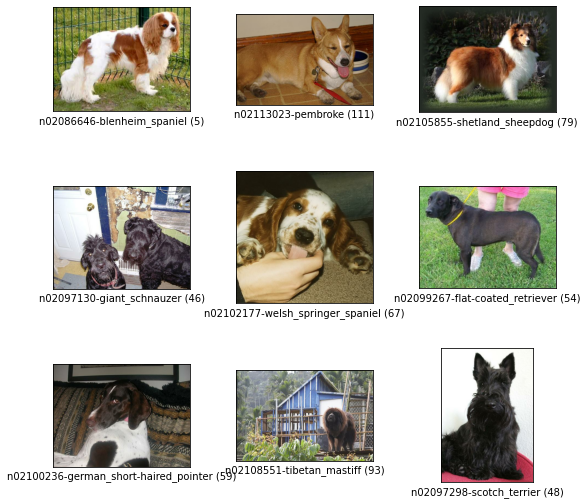

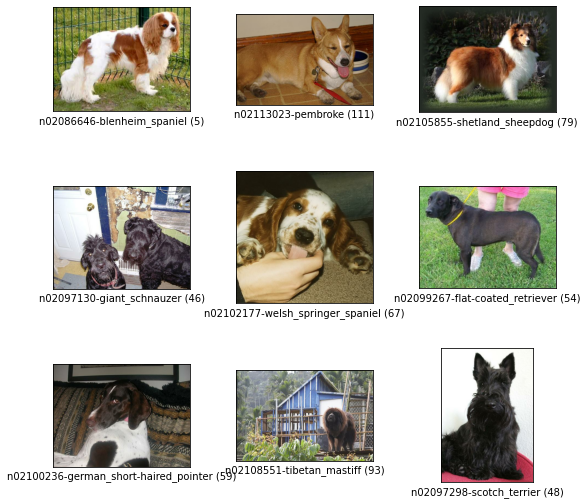

In [5]:
tfds.show_examples(ds_train, ds_info)

## 1.2 Preprocessing Data 

In [8]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [7]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

100


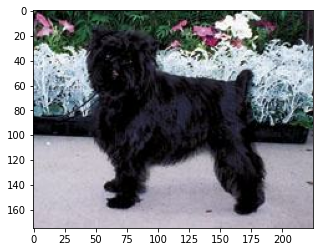

In [9]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [10]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

In [11]:
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [12]:
for input in ds_train_norm.take(1):
    image, label = input
    print(label)

tf.Tensor([ 83  79  99 103  12  29  91  32 115  75  25  21  63   8  93  94], shape=(16,), dtype=int64)


In [13]:
num_classes = ds_info.features["label"].num_classes
print("The number of Classes: ", num_classes)

The number of Classes:  120


# 2. Model
## 2.1 Load Pretrained Model - CAM

In [32]:
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [33]:
cam_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [40]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)


filepath = "./model/CAM/{epoch:02d}--{loss:.4f}-{accuracy:.4f}-{val_loss:.4f}-{val_accuracy:.4f}.h5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    save_freq="epoch",
    options=None
)

## 2.2 Train Model

In [41]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[model_checkpoint_callback],
)

Epoch 1/20
750/750 [==============================] - 160s 209ms/step - loss: 0.0332 - accuracy: 0.9983 - val_loss: 0.9802 - val_accuracy: 0.7291

Epoch 00001: saving model to ./model/CAM/01--0.0332-0.9983-0.9802-0.7291.h5
Epoch 2/20
750/750 [==============================] - 154s 206ms/step - loss: 0.0185 - accuracy: 0.9998 - val_loss: 0.9562 - val_accuracy: 0.7394

Epoch 00002: saving model to ./model/CAM/02--0.0185-0.9998-0.9562-0.7394.h5
Epoch 3/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0139 - accuracy: 0.9993 - val_loss: 0.9976 - val_accuracy: 0.7316

Epoch 00003: saving model to ./model/CAM/03--0.0139-0.9993-0.9976-0.7316.h5
Epoch 4/20
750/750 [==============================] - 154s 206ms/step - loss: 0.0104 - accuracy: 0.9998 - val_loss: 0.9741 - val_accuracy: 0.7393

Epoch 00004: saving model to ./model/CAM/04--0.0104-0.9998-0.9741-0.7393.h5
Epoch 5/20
750/750 [==============================] - 154s 206ms/step - loss: 0.0084 - accuracy: 0.9997 - va

## 2.3 Load Pretraind Model including classifier
- add flatten, dense, dropout layer  
![image1](./asset/image1.png)

# 3. Class Acitvation Mapping - Visualization 

In [110]:
def get_three_imgs(ds):
    ds = ds.take(2)
    sample_data = list(ds.as_numpy_iterator())
    return sample_data

imgs_2 = get_three_imgs(ds_test)

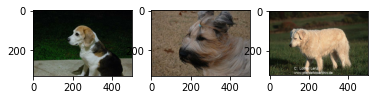

In [97]:
for img_index, img in enumerate (imgs_2):
        plt.subplot(1, 2, img_index+1)
        plt.imshow(img['image'])

In [15]:
def generate_cam(model, item):
    
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    image_tensor, class_idx = normalize_and_resize_img(item)
    
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(image_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) 
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height))
    return cam_image

Epoch: 1, Loss: 0.0332, Accuracy: 0.9983, Validation Loss: 0.9802, Validation Accuracy: 0.7291


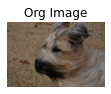

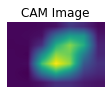

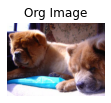

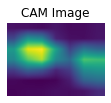

Epoch: 2, Loss: 0.0185, Accuracy: 0.9998, Validation Loss: 0.9562, Validation Accuracy: 0.7394


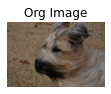

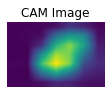

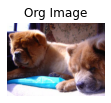

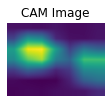

Epoch: 3, Loss: 0.0139, Accuracy: 0.9993, Validation Loss: 0.9976, Validation Accuracy: 0.7316


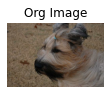

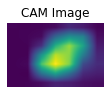

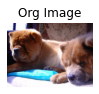

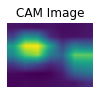

Epoch: 4, Loss: 0.0104, Accuracy: 0.9998, Validation Loss: 0.9741, Validation Accuracy: 0.7393


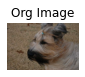

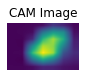

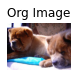

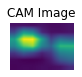

Epoch: 5, Loss: 0.0084, Accuracy: 0.9997, Validation Loss: 0.9772, Validation Accuracy: 0.7413


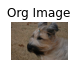

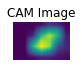

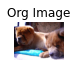

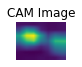

Epoch: 6, Loss: 0.0074, Accuracy: 0.9998, Validation Loss: 0.9942, Validation Accuracy: 0.7352


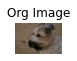

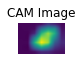

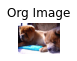

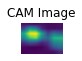

Epoch: 7, Loss: 0.0071, Accuracy: 0.9998, Validation Loss: 1.0128, Validation Accuracy: 0.732


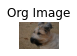

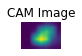

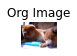

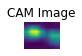

Epoch: 8, Loss: 0.0063, Accuracy: 0.9996, Validation Loss: 1.0269, Validation Accuracy: 0.7326


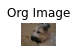

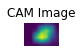

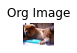

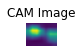

Epoch: 9, Loss: 0.0052, Accuracy: 0.9998, Validation Loss: 1.032, Validation Accuracy: 0.7301


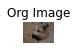

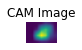

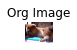

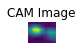

Epoch: 10, Loss: 0.0056, Accuracy: 0.9996, Validation Loss: 1.0681, Validation Accuracy: 0.7298


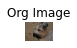

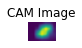

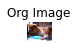

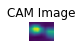

Epoch: 11, Loss: 0.0039, Accuracy: 1.0, Validation Loss: 1.0256, Validation Accuracy: 0.7362


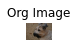

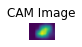

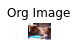

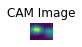

Epoch: 12, Loss: 0.004, Accuracy: 0.9998, Validation Loss: 1.0394, Validation Accuracy: 0.7354


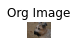

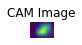

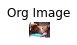

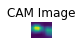

Epoch: 13, Loss: 0.0038, Accuracy: 0.9998, Validation Loss: 1.0342, Validation Accuracy: 0.7389


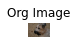

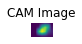

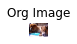

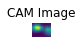

Epoch: 14, Loss: 0.0035, Accuracy: 0.9998, Validation Loss: 1.0395, Validation Accuracy: 0.7351


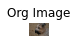

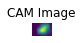

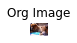

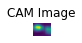

Epoch: 15, Loss: 0.0028, Accuracy: 0.9999, Validation Loss: 1.0442, Validation Accuracy: 0.7344


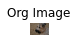

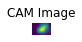

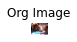

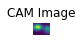

Epoch: 16, Loss: 0.0032, Accuracy: 0.9998, Validation Loss: 1.0486, Validation Accuracy: 0.7364


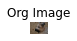

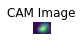

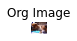

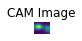

Epoch: 17, Loss: 0.0031, Accuracy: 0.9998, Validation Loss: 1.0533, Validation Accuracy: 0.7361


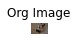

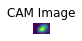

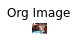

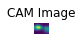

Epoch: 18, Loss: 0.0028, Accuracy: 0.9999, Validation Loss: 1.0541, Validation Accuracy: 0.7358


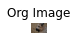

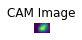

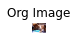

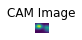

Epoch: 19, Loss: 0.0026, Accuracy: 0.9999, Validation Loss: 1.0616, Validation Accuracy: 0.7317


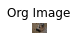

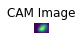

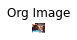

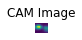

Epoch: 20, Loss: 0.0026, Accuracy: 0.9998, Validation Loss: 1.0576, Validation Accuracy: 0.7341


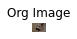

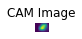

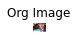

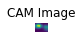

In [118]:
import os
import re

cam_model_path = "./model/CAM"

model_list = os.listdir(cam_model_path)

def extract_number(filename):
    match = re.search(r'\d+', filename)
    if match:
        return int(match.group())
    return -1 

sorted_models = sorted(model_list, key=extract_number)

for model_index, model in enumerate (sorted_models):
    loaded_model_path = "./model/CAM/" + model
    pattern = r"(\d{2})--(\d+\.\d+)-(\d+\.\d+)-(\d+\.\d+)-(\d+\.\d+)\.h5"
    match = re.match(pattern, model)
    if match:
        epoch = int(match.group(1))
        loss = float(match.group(2))
        accuracy = float(match.group(3))
        val_loss = float(match.group(4))
        val_accuracy = float(match.group(5))
    print(f"Epoch: {epoch}, Loss: {loss}, Accuracy: {accuracy}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
    
    loaded_model = keras.models.load_model(loaded_model_path)
    
    for img_index, img in enumerate (imgs_2):
        cam_image = generate_cam(loaded_model, img)
        
        plt.figure(figsize=(8,4))
        plt.subplot(model_index + 1, 4, img_index * 2 + 1)
        plt.title('Org Image')
        plt.axis('off')
        plt.imshow(img['image'])
        
        plt.figure(figsize=(8,4))
        plt.subplot(model_index + 1, 4, img_index * 2 + 2)
        plt.title('CAM Image')
        plt.axis('off')
        plt.imshow(cam_image)
        
    plt.show()

In [18]:
model_path = "./model/CAM/16--0.0032-0.9998-1.0486-0.7364.h5"
cam_model = keras.models.load_model(model_path)

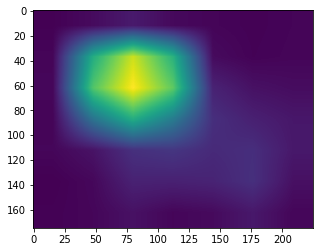

In [19]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [20]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

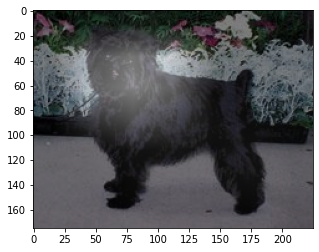

In [21]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

# 4. Gradiation Class Acitvation Mapping - Visualization  

In [14]:
def generate_grad_cam(model, activation_layer, item):

    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    grad_model = tf.keras.models.Model([model.inputs], 
                                       [model.get_layer(activation_layer).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
        
        loss = pred[:, class_idx]
        
        output = conv_output[0]
        grad_val = tape.gradient(loss, conv_output)[0]
    
    weights = np.mean(grad_val, axis=(0, 1))
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    
    for k, w in enumerate(weights):
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

In [22]:
model_path = "./model/GCAM/20--0.0025-0.9998-1.1095-0.7443.h5"
gcam_model = keras.models.load_model(model_path)

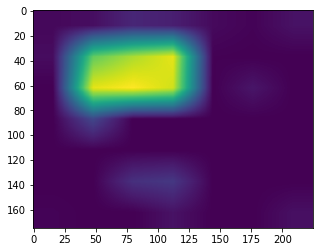

In [23]:
grad_cam_image = generate_grad_cam(gcam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

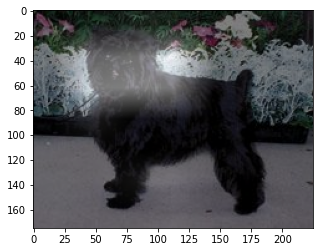

In [24]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

GCAM이 CAM보다 조금 더 보편적인 강아지 구역을 더 잘 나타내준다.

# 5. Image detection

In [56]:
def get_bbox(image, score_thresh=0.6):
    low_indicies = image <= score_thresh
    image[low_indicies] = 0
    image = (image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

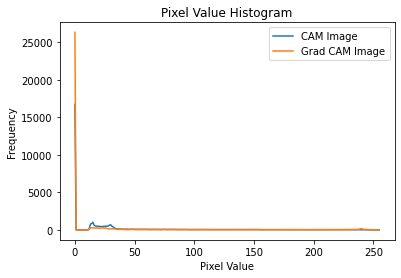

In [47]:
def get(image, score_thresh=0.05):
    low_indicies = image <= score_thresh
    image[low_indicies] = 0
    image = (image * 255).astype(np.uint8)
    return image
processed_cam_image = get(cam_image)

processed_gcam_image = get(grad_cam_image)

hist_cam, bins_cam = np.histogram(processed_cam_image.ravel(), bins=256, range=[0, 256])
hist_gcam, bins_gcam = np.histogram(processed_gcam_image.ravel(), bins=256, range=[0, 256])

# 히스토그램 시각화
plt.figure()
plt.title("Pixel Value Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.plot(hist_cam, label="CAM Image")
plt.plot(hist_gcam, label="Grad CAM Image")
plt.legend()
plt.show()

In [52]:
cam_rect = get_bbox(cam_image)
gcam_rect = get_bbox(grad_cam_image)
print(cam_rect)
print(gcam_rect)

[[ 32  34]
 [115  17]
 [128  83]
 [ 45  99]]
[[ 30  28]
 [126  21]
 [129  71]
 [ 33  78]]


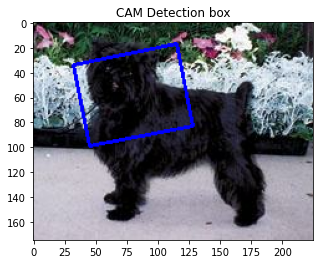

In [53]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [cam_rect], 0, (0,0,255), 2)
plt.title("CAM Detection box")
plt.imshow(image)
plt.show()

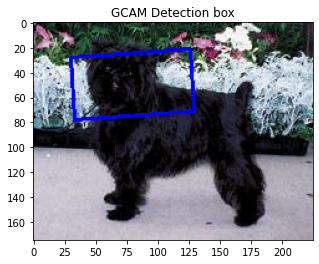

In [54]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [gcam_rect], 0, (0,0,255), 2)
plt.title("GCAM Detection box")
plt.imshow(image)
plt.show()

In [32]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  
        rect[:,0].min()/float(image.shape[1]),  
        rect[:,1].max()/float(image.shape[0]), 
        rect[:,0].max()/float(image.shape[1]) 
    ]
    return bbox

def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [33]:
cam_pred_bbox = rect_to_minmax(cam_rect, item['image'])
gcam_pred_bbox = rect_to_minmax(gcam_rect, item['image'])

print("cam_IOU:", get_iou(cam_pred_bbox, item['objects']['bbox'][0]))
print("gcam_IOU:", get_iou(gcam_pred_bbox, item['objects']['bbox'][0]))

cam_IOU: 0.3502304240403433
gcam_IOU: 0.19832063185642892


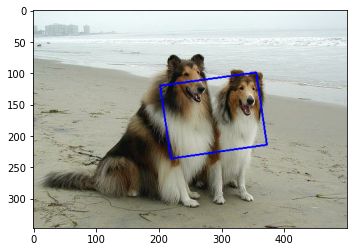

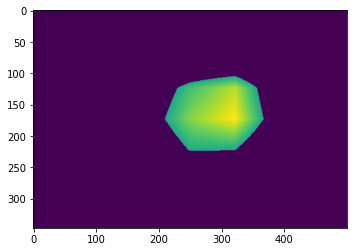

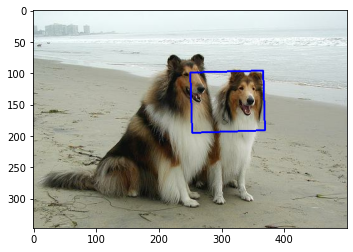

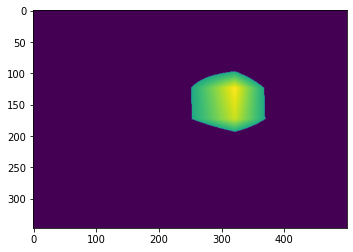

cam_iou: 0.14897819263636394, gcam_iou: 0.050434991403198515


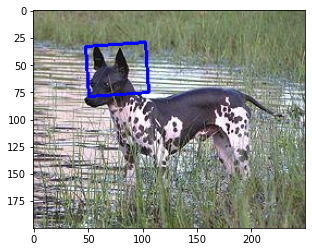

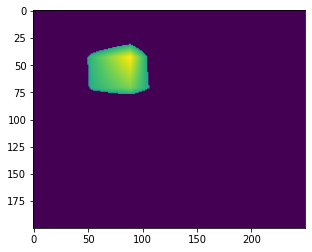

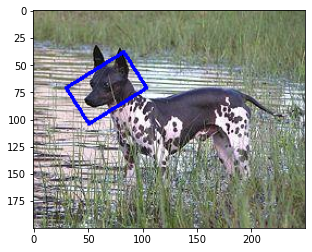

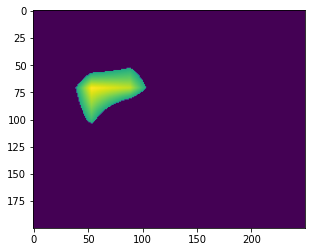

cam_iou: 0.11366250193220477, gcam_iou: 0.15129559076659785


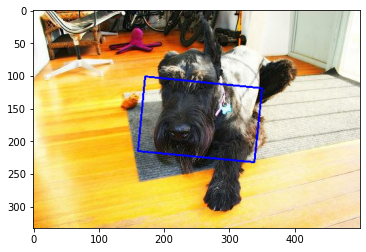

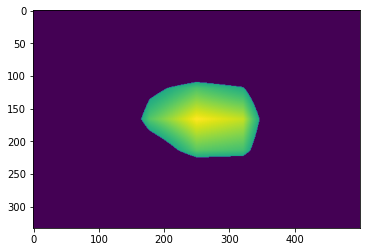

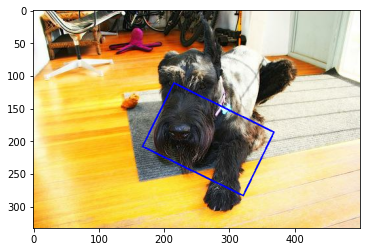

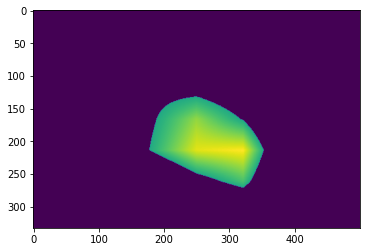

cam_iou: 0.3731943147442347, gcam_iou: 0.5453870194169634


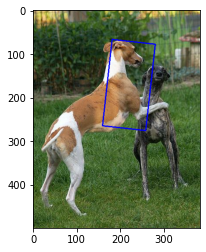

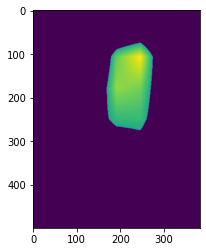

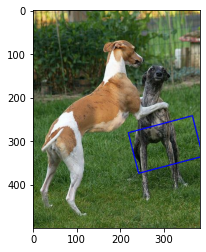

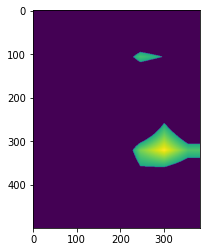

cam_iou: 0.20610419807397853, gcam_iou: 0.09388903997761452


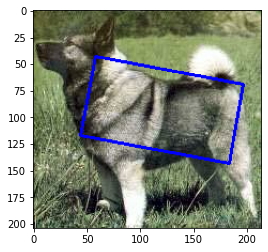

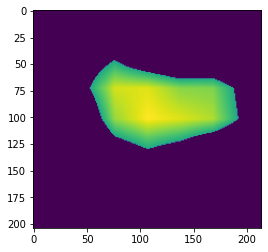

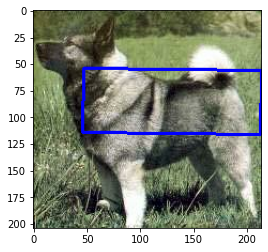

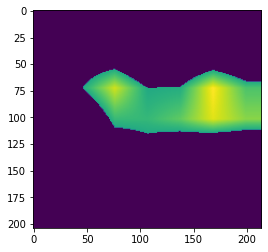

cam_iou: 0.37447647410947976, gcam_iou: 0.24557457910278638


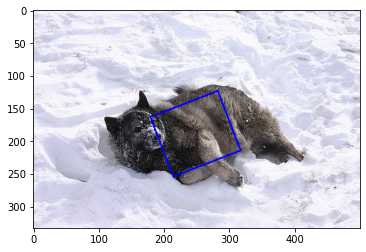

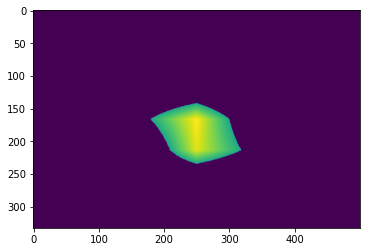

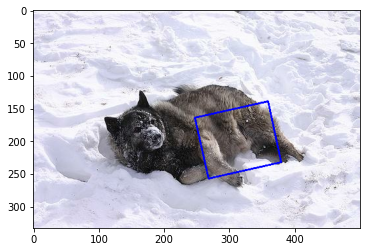

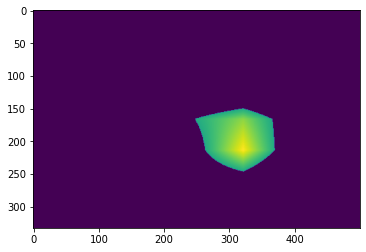

cam_iou: 0.3668425605226636, gcam_iou: 0.31607145274372217


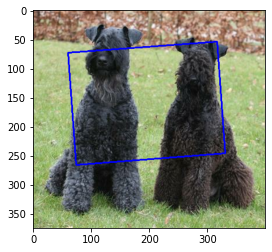

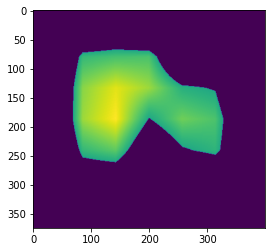

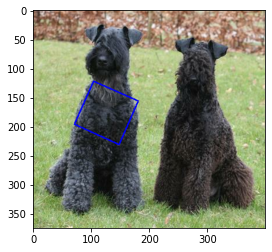

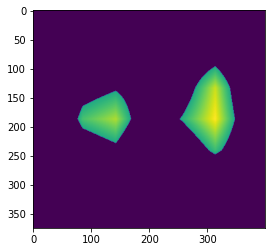

cam_iou: 0.3149123463687416, gcam_iou: 0.0


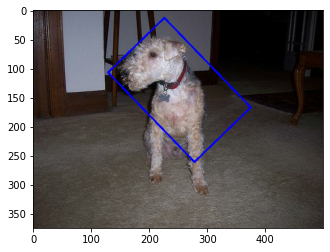

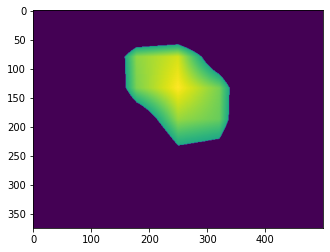

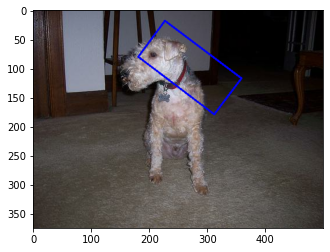

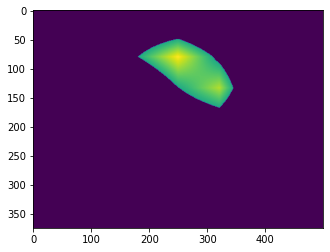

cam_iou: 0.4669456656680707, gcam_iou: 0.30142657317071475


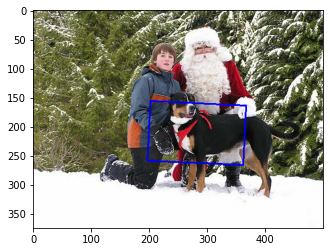

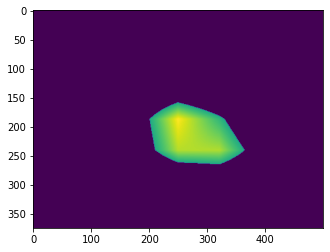

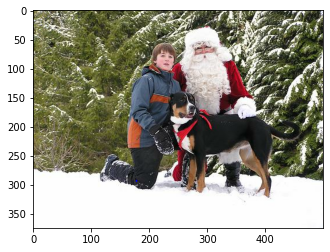

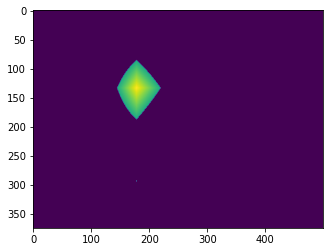

cam_iou: 0.32255978977822636, gcam_iou: 0.0


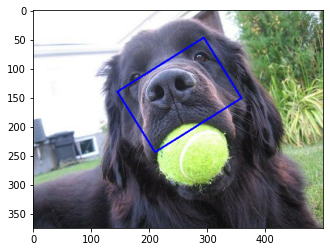

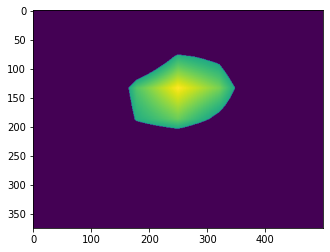

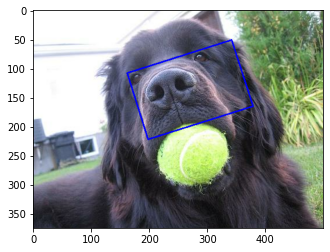

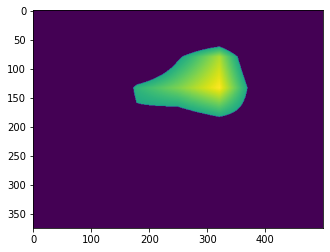

cam_iou: 0.23468045899223725, gcam_iou: 0.20656311475461236


In [60]:
def get_ten_imgs(ds):
    ds = ds.take(10)
    sample_data = list(ds.as_numpy_iterator())
    return sample_data

imgs_10 = get_ten_imgs(ds_test)

loaded_gcam_model = keras.models.load_model("./model/GCAM/20--0.0025-0.9998-1.1095-0.7443.h5")
loaded_cam_model = keras.models.load_model("./model/CAM/20--0.0026-0.9998-1.0576-0.7341.h5")

for img in imgs_10:
    cam_img = generate_cam(loaded_cam_model, img)
    gcam_img = generate_grad_cam(loaded_gcam_model,'conv5_block3_out', img)
    cam_rect = get_bbox(cam_img)
    gcam_rect = get_bbox(gcam_img)

    
    img_cam = copy.deepcopy(img['image'])
    img_cam = cv2.drawContours(img_cam, [cam_rect], 0, (0,0,255), 2)
    plt.imshow(img_cam)
    plt.show()
    plt.imshow(cam_img)
    plt.show()
    
    img_gcam = copy.deepcopy(img['image'])
    img_gcam = cv2.drawContours(img_gcam, [gcam_rect], 0, (0,0,255), 2)
    plt.imshow(img_gcam)
    plt.show()
    plt.imshow(gcam_img)
    plt.show()
    
    cam_pred_bbox = rect_to_minmax(cam_rect, img['image'])
    gcam_pred_bbox = rect_to_minmax(gcam_rect, img['image'])
    
    cam_iou = get_iou(cam_pred_bbox, img['objects']['bbox'][0])
    gcam_iou = get_iou(gcam_pred_bbox, img['objects']['bbox'][0])
    
    print(f"cam_iou: {cam_iou}, gcam_iou: {gcam_iou}")

In [63]:
import pandas as pd
import os
import re

cam_model_path = "./model/CAM"

model_list = os.listdir(cam_model_path)

def extract_number(filename):
    match = re.search(r'\d+', filename)
    if match:
        return int(match.group())
    return -1 

sorted_models = sorted(model_list, key=extract_number)

for model_index, model in enumerate (sorted_models):
    loaded_model_path = "./model/CAM/" + model
    pattern = r"(\d{2})--(\d+\.\d+)-(\d+\.\d+)-(\d+\.\d+)-(\d+\.\d+)\.h5"
    match = re.match(pattern, model)
    if match:
        epoch = int(match.group(1))
        loss = float(match.group(2))
        accuracy = float(match.group(3))
        val_loss = float(match.group(4))
        val_accuracy = float(match.group(5))
    
    loaded_model = keras.models.load_model(loaded_model_path)
    
    cam_iou = []
    for img_index, img in enumerate (imgs_10):
        cam_img = generate_cam(loaded_model, img)
        cam_rect = get_bbox(cam_img, )
        cam_pred_bbox = rect_to_minmax(cam_rect, img['image'])
        iou = get_iou(cam_pred_bbox, img['objects']['bbox'][0])
        iou = round(iou, 3)
        cam_iou.append(iou)
        
    print(f"Epoch: {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
    data = {'Image Index': range(len(cam_iou)), 'CAM IOU': cam_iou}
    df = pd.DataFrame(data)
    print(df)

Epoch: 1, Validation Loss: 0.9802, Validation Accuracy: 0.7291
   Image Index  CAM IOU
0            0    0.138
1            1    0.146
2            2    0.382
3            3    0.203
4            4    0.363
5            5    0.382
6            6    0.307
7            7    0.462
8            8    0.396
9            9    0.213
Epoch: 2, Validation Loss: 0.9562, Validation Accuracy: 0.7394
   Image Index  CAM IOU
0            0    0.137
1            1    0.136
2            2    0.375
3            3    0.172
4            4    0.397
5            5    0.374
6            6    0.319
7            7    0.455
8            8    0.351
9            9    0.226
Epoch: 3, Validation Loss: 0.9976, Validation Accuracy: 0.7316
   Image Index  CAM IOU
0            0    0.139
1            1    0.141
2            2    0.372
3            3    0.188
4            4    0.367
5            5    0.408
6            6    0.324
7            7    0.465
8            8    0.377
9            9    0.233
Epoch: 4, Validatio

In [64]:
gcam_model_path = "./model/GCAM"

model_list = os.listdir(gcam_model_path)

def extract_number(filename):
    match = re.search(r'\d+', filename)
    if match:
        return int(match.group())
    return -1 

sorted_models = sorted(model_list, key=extract_number)

for model_index, model in enumerate (sorted_models):
    loaded_model_path = "./model/GCAM/" + model
    pattern = r"(\d{2})--(\d+\.\d+)-(\d+\.\d+)-(\d+\.\d+)-(\d+\.\d+)\.h5"
    match = re.match(pattern, model)
    if match:
        epoch = int(match.group(1))
        loss = float(match.group(2))
        accuracy = float(match.group(3))
        val_loss = float(match.group(4))
        val_accuracy = float(match.group(5))
    
    loaded_model = keras.models.load_model(loaded_model_path)
    
    gcam_iou = []
    for img_index, img in enumerate (imgs_10):
        gcam_img = generate_grad_cam(gcam_model, 'conv5_block3_out', img)
        gcam_rect = get_bbox(gcam_img)
        gcam_pred_bbox = rect_to_minmax(gcam_rect, img['image'])
        iou = get_iou(gcam_pred_bbox, img['objects']['bbox'][0])
        iou = round(iou, 3)
        gcam_iou.append(iou)
        
    print(f"Epoch: {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
    data = {'Image Index': range(len(gcam_iou)), 'GCAM IOU': gcam_iou}
    df = pd.DataFrame(data)
    print(df)

Epoch: 1, Validation Loss: 1.0655, Validation Accuracy: 0.7435
   Image Index  GCAM IOU
0            0     0.050
1            1     0.151
2            2     0.545
3            3     0.094
4            4     0.246
5            5     0.316
6            6     0.000
7            7     0.301
8            8     0.000
9            9     0.207
Epoch: 2, Validation Loss: 1.0963, Validation Accuracy: 0.7401
   Image Index  GCAM IOU
0            0     0.050
1            1     0.151
2            2     0.545
3            3     0.094
4            4     0.246
5            5     0.316
6            6     0.000
7            7     0.301
8            8     0.000
9            9     0.207
Epoch: 3, Validation Loss: 1.0703, Validation Accuracy: 0.7436
   Image Index  GCAM IOU
0            0     0.050
1            1     0.151
2            2     0.545
3            3     0.094
4            4     0.246
5            5     0.316
6            6     0.000
7            7     0.301
8            8     0.000
9          

# Retrospective
1. ACOL 논문에 기반하여 threshold는 0.5~0.8사이로 설정해야 정확한 bounding box를 도출할 수 있다.  
2. tfds에서 제공하는 Bounding box와 일치하는 box를 도출하기에는 무리가 있다.   
3. GCAM & CAM 모두 image detection하고 시각화 할 수 있다는 것에 장점이 있다.  